### Tarento AI Coding Assignment

#### Question 1: Handwritten Digit Recognition using MNIST dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


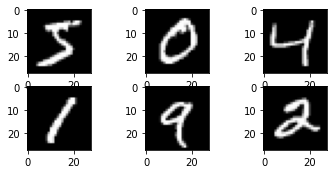

In [2]:
# loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first 6 images
for i in range(6):
 # define subplot
 plt.subplot(330 + 1 + i)
 # plot raw pixel data
 plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

We can see that there are 60,000 examples in the training dataset and 10,000 in the test dataset and that images are indeed square with 28×28 pixels

We know some things about the dataset.

For example, we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale.

Therefore, we can load the images and reshape the data arrays to have a single color channel.

We also know that there are 10 classes and that classes are represented as unique integers.

We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes. We can achieve this with the to_categorical() utility function.

In [5]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [6]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

Next, we need to define a baseline convolutional neural network model for the problem

In [8]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

After the model is defined, we need to evaluate it.

The model will be evaluated using five-fold cross-validation. The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.

In [10]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

Once the model has been evaluated, we can present the results.

There are two key aspects to present: the diagnostics of the learning behavior of the model during training and the estimation of the model performance. These can be implemented using separate functions.

First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.

We will create a single figure with two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. The summarize_diagnostics() function below creates and shows this plot given the collected training histories.

In [11]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

We need a function that will drive the test harness.

This involves calling all of the define functions.

> 98.517
> 98.633
> 98.692
> 98.900
> 98.750


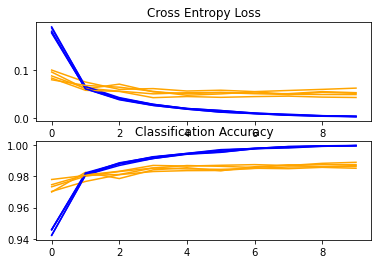

Accuracy: mean=98.698 std=0.127, n=5


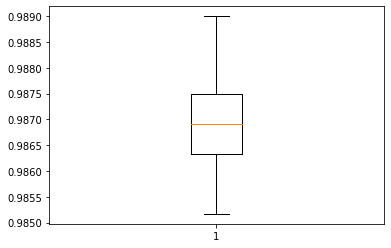

In [12]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

# entry point, run the test harness
run_test_harness()

Next, a diagnostic plot is shown, giving insight into the learning behavior of the model across each fold.

In this case, we can see that the model generally achieves a good fit, with train and test learning curves converging. There is no obvious sign of over- or underfitting.

Next, a summary of the model performance is calculated.

We can see in this case, the model has an estimated skill of about 98.6%, which is reasonable.

Finally, a box and whisker plot is created to summarize the distribution of accuracy scores.

#### Q2. Designing a neural network architecture to perform slot filling on ATIS Dataset

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Bidirectional, LSTM, TimeDistributed

# Load the ATIS dataset
df = pd.read_csv('atis_intents_train.csv')

# Extract input sequences and slot labels
X = df['utterance'].values
y = df['slot_labels'].values

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the vocabulary size and maximum sequence length
max_words = 10000
max_len = 50

# Tokenize the input sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

# Pad the input sequences
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_val = pad_sequences(X_val, padding='post', maxlen=max_len)

# Define the slot label vocabulary and convert labels to one-hot vectors
tags = list(set(df['slot_labels'].values))
num_tags = len(tags)
tag2idx = {t:i for i,t in enumerate(tags)}
y_train = [[tag2idx[tag] for tag in sentence.split()] for sentence in y_train]
y_val = [[tag2idx[tag] for tag in sentence.split()] for sentence in y_val]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=num_tags-1)
y_val = pad_sequences(maxlen=max_len, sequences=y_val, padding="post", value=num_tags-1)
y_train = [to_categorical(i, num_classes=num_tags) for i in y_train]
y_val = [to_categorical(i, num_classes=num_tags) for i in y_val]

# Define the neural network architecture
inputs = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=128, mask_zero=True)(inputs)
lstm_layer = Bidirectional(LSTM(units=64, return_sequences=True))(embedding_layer)
output_layer = TimeDistributed(Dense(num_tags, activation='softmax'))(lstm_layer)
model = Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# Train the model
model.fit(X_train, np.array(y_train), validation_data=(X_val, np.array(y_val)), batch_size=32, epochs=5)

# Test the model on a sample input sequence
test_sequence = "what is the cheapest flight from boston to atlanta"
test_sequence = tokenizer.texts_to_sequences([test_sequence])
test_sequence = pad_sequences(test_sequence, padding='post', maxlen=max_len)
pred = model.predict(test_sequence)
pred_tags = [tags[np.argmax(p)] for p in pred[0]]
print(pred_tags)